In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [45]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create inspector and connect to the engine
inspector = inspect(engine)

In [11]:
# Use inspector to view columns and type
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Use inspector to view columns and type
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [14]:
# Calculate the last date in the database
first_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
first_date

('2017-08-23')

In [15]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).all()
print(precipitation)

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns = ['date','prcp'])
precipitation_df.set_index(['date'], inplace = True)
precipitation_df

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [18]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('date')
precipitation_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


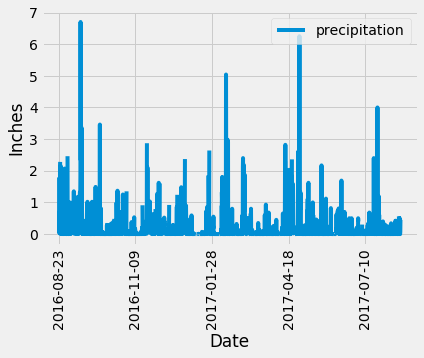

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot = 90)
plt.legend(['precipitation'],loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_data = session.query(measurement.station, func.min(measurement.tobs),
                                 func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
most_active_data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').filter(measurement.date >= query_date).all()
tobs

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 

In [25]:
tobs_df = pd.DataFrame(tobs)
tobs_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


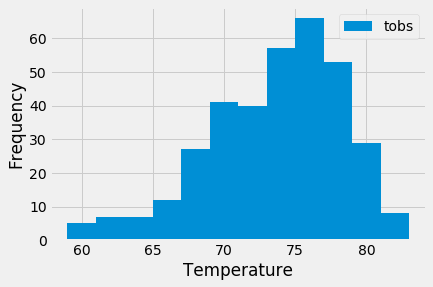

In [26]:
tobs_df.plot.hist(by=tobs, bins=12)
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [57]:
# Temperature Analysis 1
# Identify the average temperature in June at all stations across all available years in the dataset.
june_avgs = session.query(measurement.station, measurement.tobs).\
    filter(func.strftime('%m', measurement.date) == '06').all()
june_df = pd.DataFrame(june_avgs)
june_df

,station,tobs
0,USC00519397,78.0
1,USC00519397,76.0
2,USC00519397,78.0
3,USC00519397,76.0
4,USC00519397,77.0
...,...,...
1695,USC00516128,79.0
1696,USC00516128,74.0
1697,USC00516128,74.0
1698,USC00516128,76.0


In [58]:
# Do the same for December temperature.
dec_avgs = session.query(measurement.station, measurement.tobs).\
    filter(func.strftime('%m', measurement.date) == '12').all()
dec_df = pd.DataFrame(dec_avgs)
dec_df

,station,tobs
0,USC00519397,76.0
1,USC00519397,74.0
2,USC00519397,74.0
3,USC00519397,64.0
4,USC00519397,64.0
...,...,...
1512,USC00516128,71.0
1513,USC00516128,71.0
1514,USC00516128,69.0
1515,USC00516128,65.0


In [60]:
june_mean = june_df['tobs'].mean()
june_mean

74.94411764705882

In [61]:
dec_mean = dec_df['tobs'].mean()
dec_mean

71.04152933421226

In [62]:
# Comparing to ttest values to determine validity
june_mean - dec_mean

3.902588312846561

In [63]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant.
# Will you use a paired t-test, or an unpaired t-test? Why?
###################################################################
# Using an upaired t-test because the 2 data sets are independent being from different months.
# The p value is very low showing strong correlation and that the data sets are good.
stats.ttest_ind(june_df['tobs'], dec_df['tobs'])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [136]:
# Temperature Analysis 2
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [137]:
print(calc_temps('2017-07-20', '2017-07-27'))

[(72.0, 78.38461538461539, 84.0)]


In [143]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    start_date = dt.date(2012, 2, 28) - dt.timedelta(days=365)
    end_date = dt.date(2012, 3, 5) - dt.timedelta(days=365)
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(61.0, 70.08928571428571, 75.0)]


In [149]:
def calc_temps(start_date, end_date):
    
    start_date = dt.date(2017, 7, 20) - dt.timedelta(days=365)
    end_date = dt.date(2017, 7, 27) - dt.timedelta(days=365)
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

In [150]:
tmin, tavg, tmax = calc_temps('2017-07-20', '2017-07-27')[0]
print(tmin, tavg, tmax)

74.0 78.26086956521739 83.0


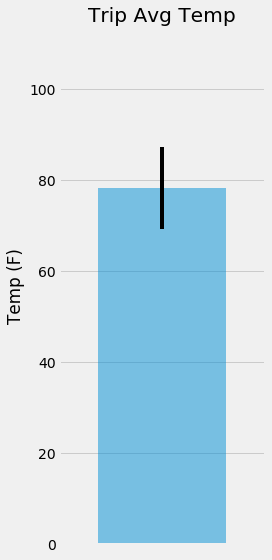

In [151]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2))
yerr = tmax - tmin
ax.bar(1, tavg, yerr=yerr, align='center', alpha=0.5)
ax.set(xticks = range(1))
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
ax.margins(.3, .3)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [116]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-07-20' 
end_date = '2016-07-27'
sel = [station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)]

session.query(*sel).filter(station.station == measurement.station).\
    filter(measurement.date >= start_date).filter(measurement.date <= end_date).\
    group_by(station.name).\
    order_by(func.sum(measurement.prcp).desc()).all()

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  11.280000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  8.249999999999998),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 8.08),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  4.390000000000001),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  3.2699999999999996),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0)]

In [123]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [124]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

In [152]:
# Set the start and end date of the trip
start_date = '2017-07-20' 
end_date = '2017-07-27'

In [153]:
# Use the start and end date to create a range of dates
date_range = pd.date_range(start = start_date, end = end_date)
date_range

DatetimeIndex(['2017-07-20', '2017-07-21', '2017-07-22', '2017-07-23',
               '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-27'],
              dtype='datetime64[ns]', freq='D')

In [168]:
# Strip off the year and save a list of %m-%d strings
trip_dates = date_range.strftime("%m-%d")
trip_dates

Index(['07-20', '07-21', '07-22', '07-23', '07-24', '07-25', '07-26', '07-27'], dtype='object')


In [164]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
    
for date in trip_dates:
    normals.append(*daily_normals(date))

normals

[(69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0)]

In [192]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns =['tmin', 'tavg', 'tmax'],
            index=pd.date_range(start='2017-07-20', end='2017-07-27', freq='D'))
# normals_df['date'] = trip_dates
# normals_df.set_index('date')
normals_df

,tmin,tavg,tmax
2017-07-20,69.0,75.462963,82.0
2017-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0
2017-07-23,70.0,76.203704,84.0
2017-07-24,69.0,76.555556,81.0
2017-07-25,67.0,76.890909,84.0
2017-07-26,71.0,76.442308,86.0
2017-07-27,68.0,76.581818,83.0


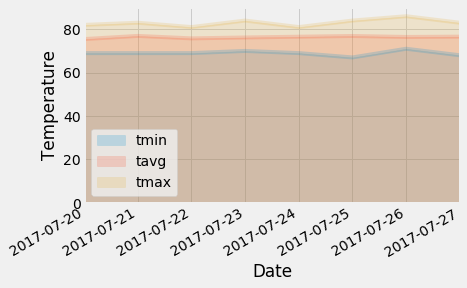

In [212]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha = .2, x_compat=True)
plt.legend(loc = 'lower left')
plt.margins(0)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.show()